### Clustering of words based on UMAP and sbert
[sbert](https://www.sbert.net/)
[UMAP](https://umap-learn.readthedocs.io/en/latest/index.html)

In [13]:
import json
# Used to import data from S3.
import pandas as pd

# Used to create the dense document vectors.
import torch
from sentence_transformers import SentenceTransformer

# Used to create and store the Faiss index.
import faiss
import numpy as np
import pickle
import matplotlib.pyplot as plt

# Used to do vector searches and display the results.
#from vector_engine.utils import vector_search, id2details

### Import
Import the file exported from the excel file

In [14]:
defFile1 = "primitiveDef.json"
defFile2 = "skillDef.json"
defFile3 = "taskDef.json"

with open('D:/1. Papers/4. MyPapers/6_(20210609) Skill taxonomy/skill-taxonomy-extraction/data/in/' + str(defFile1)) as json_file:
    defWord1 = json.load(json_file)

with open('D:/1. Papers/4. MyPapers/6_(20210609) Skill taxonomy/skill-taxonomy-extraction/data/in/' + str(defFile2)) as json_file:
    defWord2 = json.load(json_file)

with open('D:/1. Papers/4. MyPapers/6_(20210609) Skill taxonomy/skill-taxonomy-extraction/data/in/' + str(defFile3)) as json_file:
    defWord3 = json.load(json_file)


defWord = defWord1 + defWord2 + defWord3

print(len(defWord))

556


### Preprocessing
Follow guide from: https://www.pinecone.io/learn/faiss-tutorial/

In [15]:
# remove duplicates
defSing = [word for word in list(set(defWord)) if type(word) is str]

print(len(defSing))

334


In [16]:
from sentence_transformers import SentenceTransformer
# initialize sentence transformer model
#model = SentenceTransformer('bert-base-nli-mean-tokens') #this is outdated: https://huggingface.co/sentence-transformers/bert-base-nli-mean-tokens
# info: https://www.sbert.net/docs/pretrained_models.html
model = SentenceTransformer('all-mpnet-base-v2')
# create sentence embeddings
sentence_embeddings = model.encode(defSing)
sentence_embeddings.shape
#print(sentence_embeddings)

(334, 768)

### Clustering
We now follow the guide of topic modelling, [guide](https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6)

In [17]:
n_neighbors=5
n_components=2

import umap
umap_embeddings = umap.UMAP(n_neighbors=n_neighbors, 
                            n_components=n_components, 
                            metric='cosine').fit_transform(sentence_embeddings)

In [18]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=5,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

19


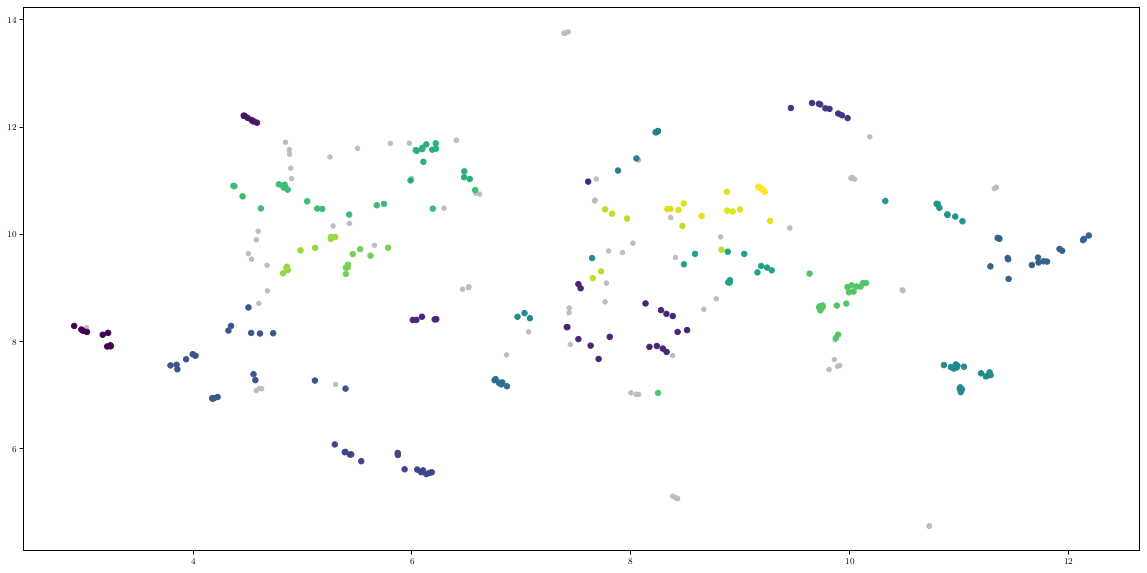

In [19]:
import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=n_neighbors, n_components=n_components, min_dist=0.0, metric='cosine').fit_transform(sentence_embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

#print(result)

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
print(max(result.labels))
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=20)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=30, cmap='viridis')
#plt.colorbar()

In [20]:
d = {'primitive':defSing, 'cluster':result['labels'], 'x': result['x'], 'y': result['y']}

clusterDF = pd.DataFrame(d)
clusterDF['Doc_ID'] = range(len(clusterDF))

primitivesPerTopic = clusterDF.groupby(['cluster'], as_index = False).agg({'primitive': ' '.join})

As suggested by this [guide](https://towardsdatascience.com/keyword-extraction-with-bert-724efca412ea) we get the most recurring keywords for each cluster

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
# group by "X" column
groups = primitivesPerTopic.groupby('cluster')
  
labels = []

# extract keys from groups
keys = groups.groups.keys()

for i in keys:

    groups.get_group(i)

    n_gram_range = (1, 1)
    stop_words = "english"

    # Extract candidate words/phrases
    count = CountVectorizer(ngram_range=n_gram_range, stop_words=stop_words).fit(groups.get_group(i)['primitive'])
    candidates = count.get_feature_names()

    model = SentenceTransformer('msmarco-distilbert-base-tas-b')
    doc_embedding = model.encode(groups.get_group(i)['primitive'].to_list())
    candidate_embeddings = model.encode(candidates)

    top_n = 2
    distances = cosine_similarity(doc_embedding, candidate_embeddings)
    keywords = [candidates[index] for index in distances.argsort()[0][-top_n:]]
    print("GROUP: " + str(i))
    #print(keywords)

    matchedKeywords = str(keywords[0] + "-" + keywords[1])
    print(matchedKeywords)

    
    labels.append(matchedKeywords)

    # need to add names to each of the group for visualization

GROUP: -1
ptp-collision
GROUP: 0
hole-peg
GROUP: 1
actuate-gripper
GROUP: 2
process-manipulation
GROUP: 3
screw-screwdriver
GROUP: 4
tray-inspection
GROUP: 5
solder-attach
GROUP: 6
navigate-guide
GROUP: 7
orientation-compare
GROUP: 8
calibration-haptic
GROUP: 9
detect-tilt
GROUP: 10
position-lin
GROUP: 11
transport-backpack
GROUP: 12
grab-grasp
GROUP: 13
wipe-remove
GROUP: 14
motion-trajectory
GROUP: 15
insert-insertion
GROUP: 16
poke-push
GROUP: 17
locate-object
GROUP: 18
place-pick
GROUP: 19
block-pick


In [22]:
# By knowing the names extracted from the clusters we can then assign them to the clusterDF which can plot the scatter plot
labelsLong = []
clusterDF["keyword"] = ""

for idx, row in clusterDF.iterrows(): 

    for i in range(len(labels)):
        if clusterDF.iloc[idx]["cluster"] == (i-1):
            clusterDF.at[idx, 'keyword'] = labels[i]
            #print(clusterDF.iloc[idx]["keyword"])

print(max(clusterDF["cluster"]))
print(min(clusterDF["x"]))
print(max(clusterDF["x"]))
print(min(clusterDF["y"]))
print(max(clusterDF["y"]))

19
2.9138572216033936
12.185802459716797
4.553910732269287
13.774715423583984


C:\Users\z0040kve\AppData\Local\Temp/ipykernel_17524/352232466.py:68: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


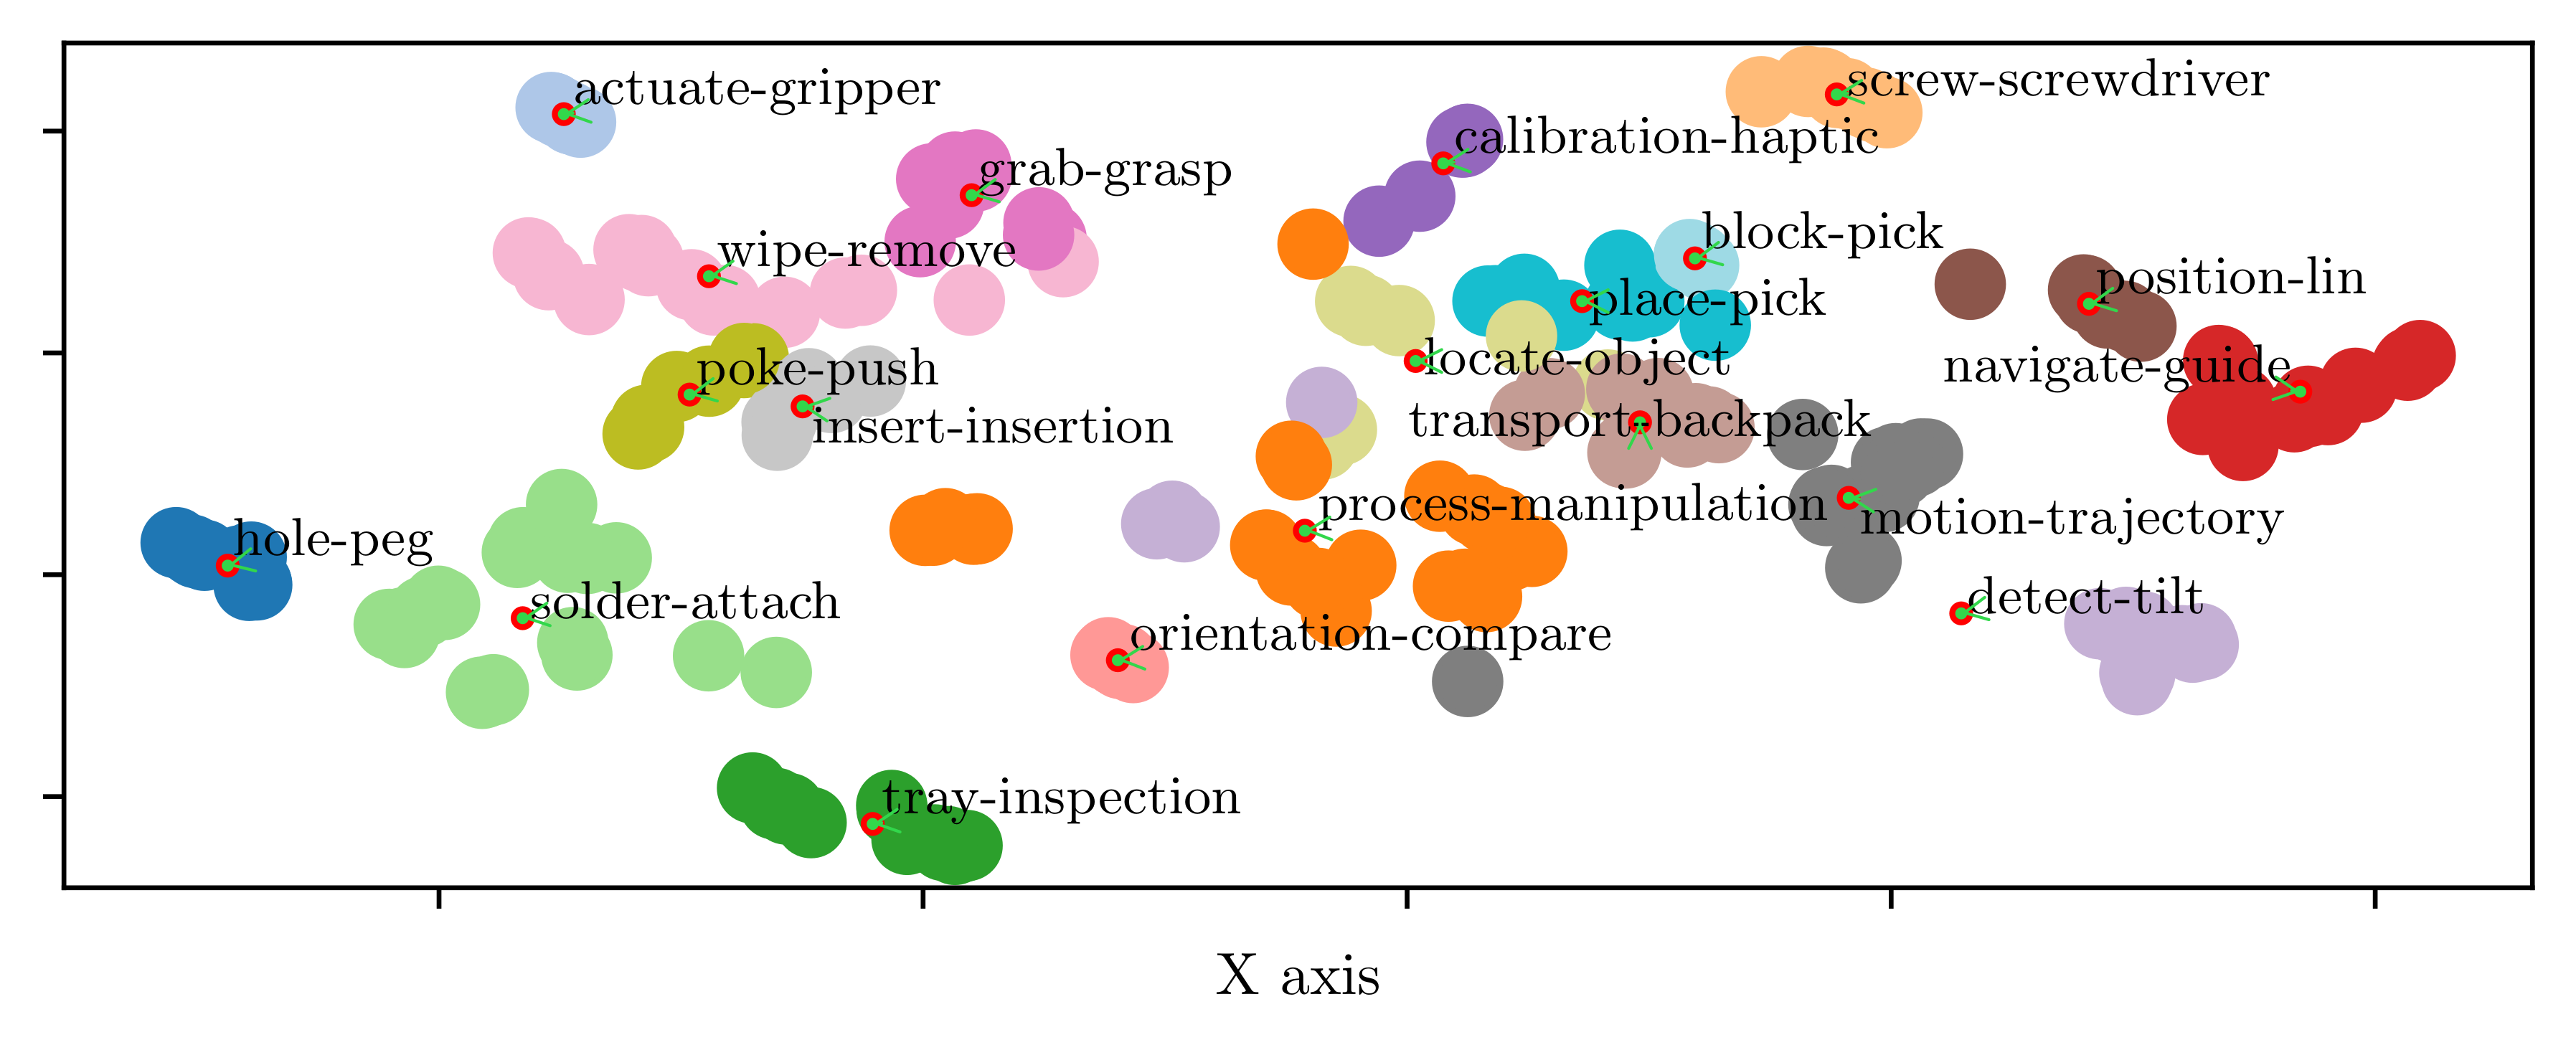

In [23]:
import numpy as np

import matplotlib
from matplotlib import pyplot as plt
from adjustText import adjust_text # to avoid overlapping text

# Latex export
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

# Visualize clusters with most appearing keywords
# (20,10)
fig, ax = plt.subplots(figsize=(7.4, 2.6), dpi=600)
outliers = clusterDF.loc[clusterDF.cluster == -1, :]
clustered = clusterDF.loc[clusterDF.cluster != -1, :]
plt.rcParams.update({'font.size': 9.5})
#pri

#plt.figure(figsize=(3240/600, 1280/600), dpi=600)

#plt.scatter(outliers.x, outliers.y, color='#F2F2F2', s=30)
plt.scatter(clustered.x, clustered.y, c=clustered.cluster, s=120, cmap='tab20')
#plt.colorbar()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])

#loop through labels and plot each cluster

# group by "X" column
groups = clustered.groupby('cluster')
  
# extract keys from groups
keys = groups.groups.keys()
texts = []

for i in keys:

    x = groups.get_group(i)['x'].mean()
    y = groups.get_group(i)['y'].mean()
    
    
    plt.plot(x, y, marker="o", markersize=3, markeredgecolor="red", markerfacecolor="#32d74b")
    #plt.annotate(groups.get_group(i).iloc[0]["keyword"], xy = (x,y))
    texts.append(plt.text(x, y, groups.get_group(i).iloc[0]["keyword"]))

#plt.xticks(color='w')
#plt.yticks(color='w')

plt.xlabel("X axis", fontsize=10)

#visualiplt.ylabel("Dimension 2", fontsize=10)

# import tikzplotlib

# tikzplotlib.save("D:/1. Papers/4. MyPapers/6_(20210609) Skill taxonomy/figures/knnClusteringWords.tex")
#plt.plot([6.5, 6.5], [8, 14], color='#32d74b', linestyle='--', linewidth=0.6)
#plt.plot([2, 9], [11, 11], color='#32d74b', linestyle='--', linewidth=0.6)
# adjust_text(texts, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(arrowstyle="->", color='r', lw=0.5))
adjust_text(texts, only_move={'points':'x','texts':'y','objects':'x'}, arrowprops=dict(arrowstyle="->", color='#32d74b', lw=0.5))
#plt.plot([3, 11], [10.5, 10.5], color='#8A8AFF', linestyle='--', linewidth=1)

plt.savefig('D:/1. Papers/4. MyPapers/6_(20210609) Skill taxonomy/figures/knnClusteringWords.pgf', dpi=600, bbox_inches = 'tight')
plt.show()

Here we want to perform hiererchical clustering without outliers

In [24]:
embd_list = []

for i in range(len(sentence_embeddings)):
    embd_list.append(i)

print(len(sentence_embeddings))
print(len(embd_list))

d = {'primitive':clusterDF['primitive'].to_list(),'cluster':clusterDF['cluster'].to_list(), 'embedding': embd_list}

clustersEmbeddings = pd.DataFrame(d)

clusteredEmb = clustersEmbeddings.loc[clustersEmbeddings.cluster != -1, :]

CLUSTEREDsentence_embeddings =  np.array(sentence_embeddings)[clusteredEmb['embedding'].to_list()]   

334
334


In [25]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering

dataset = CLUSTEREDsentence_embeddings

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(dataset)

print(len(dataset))

246


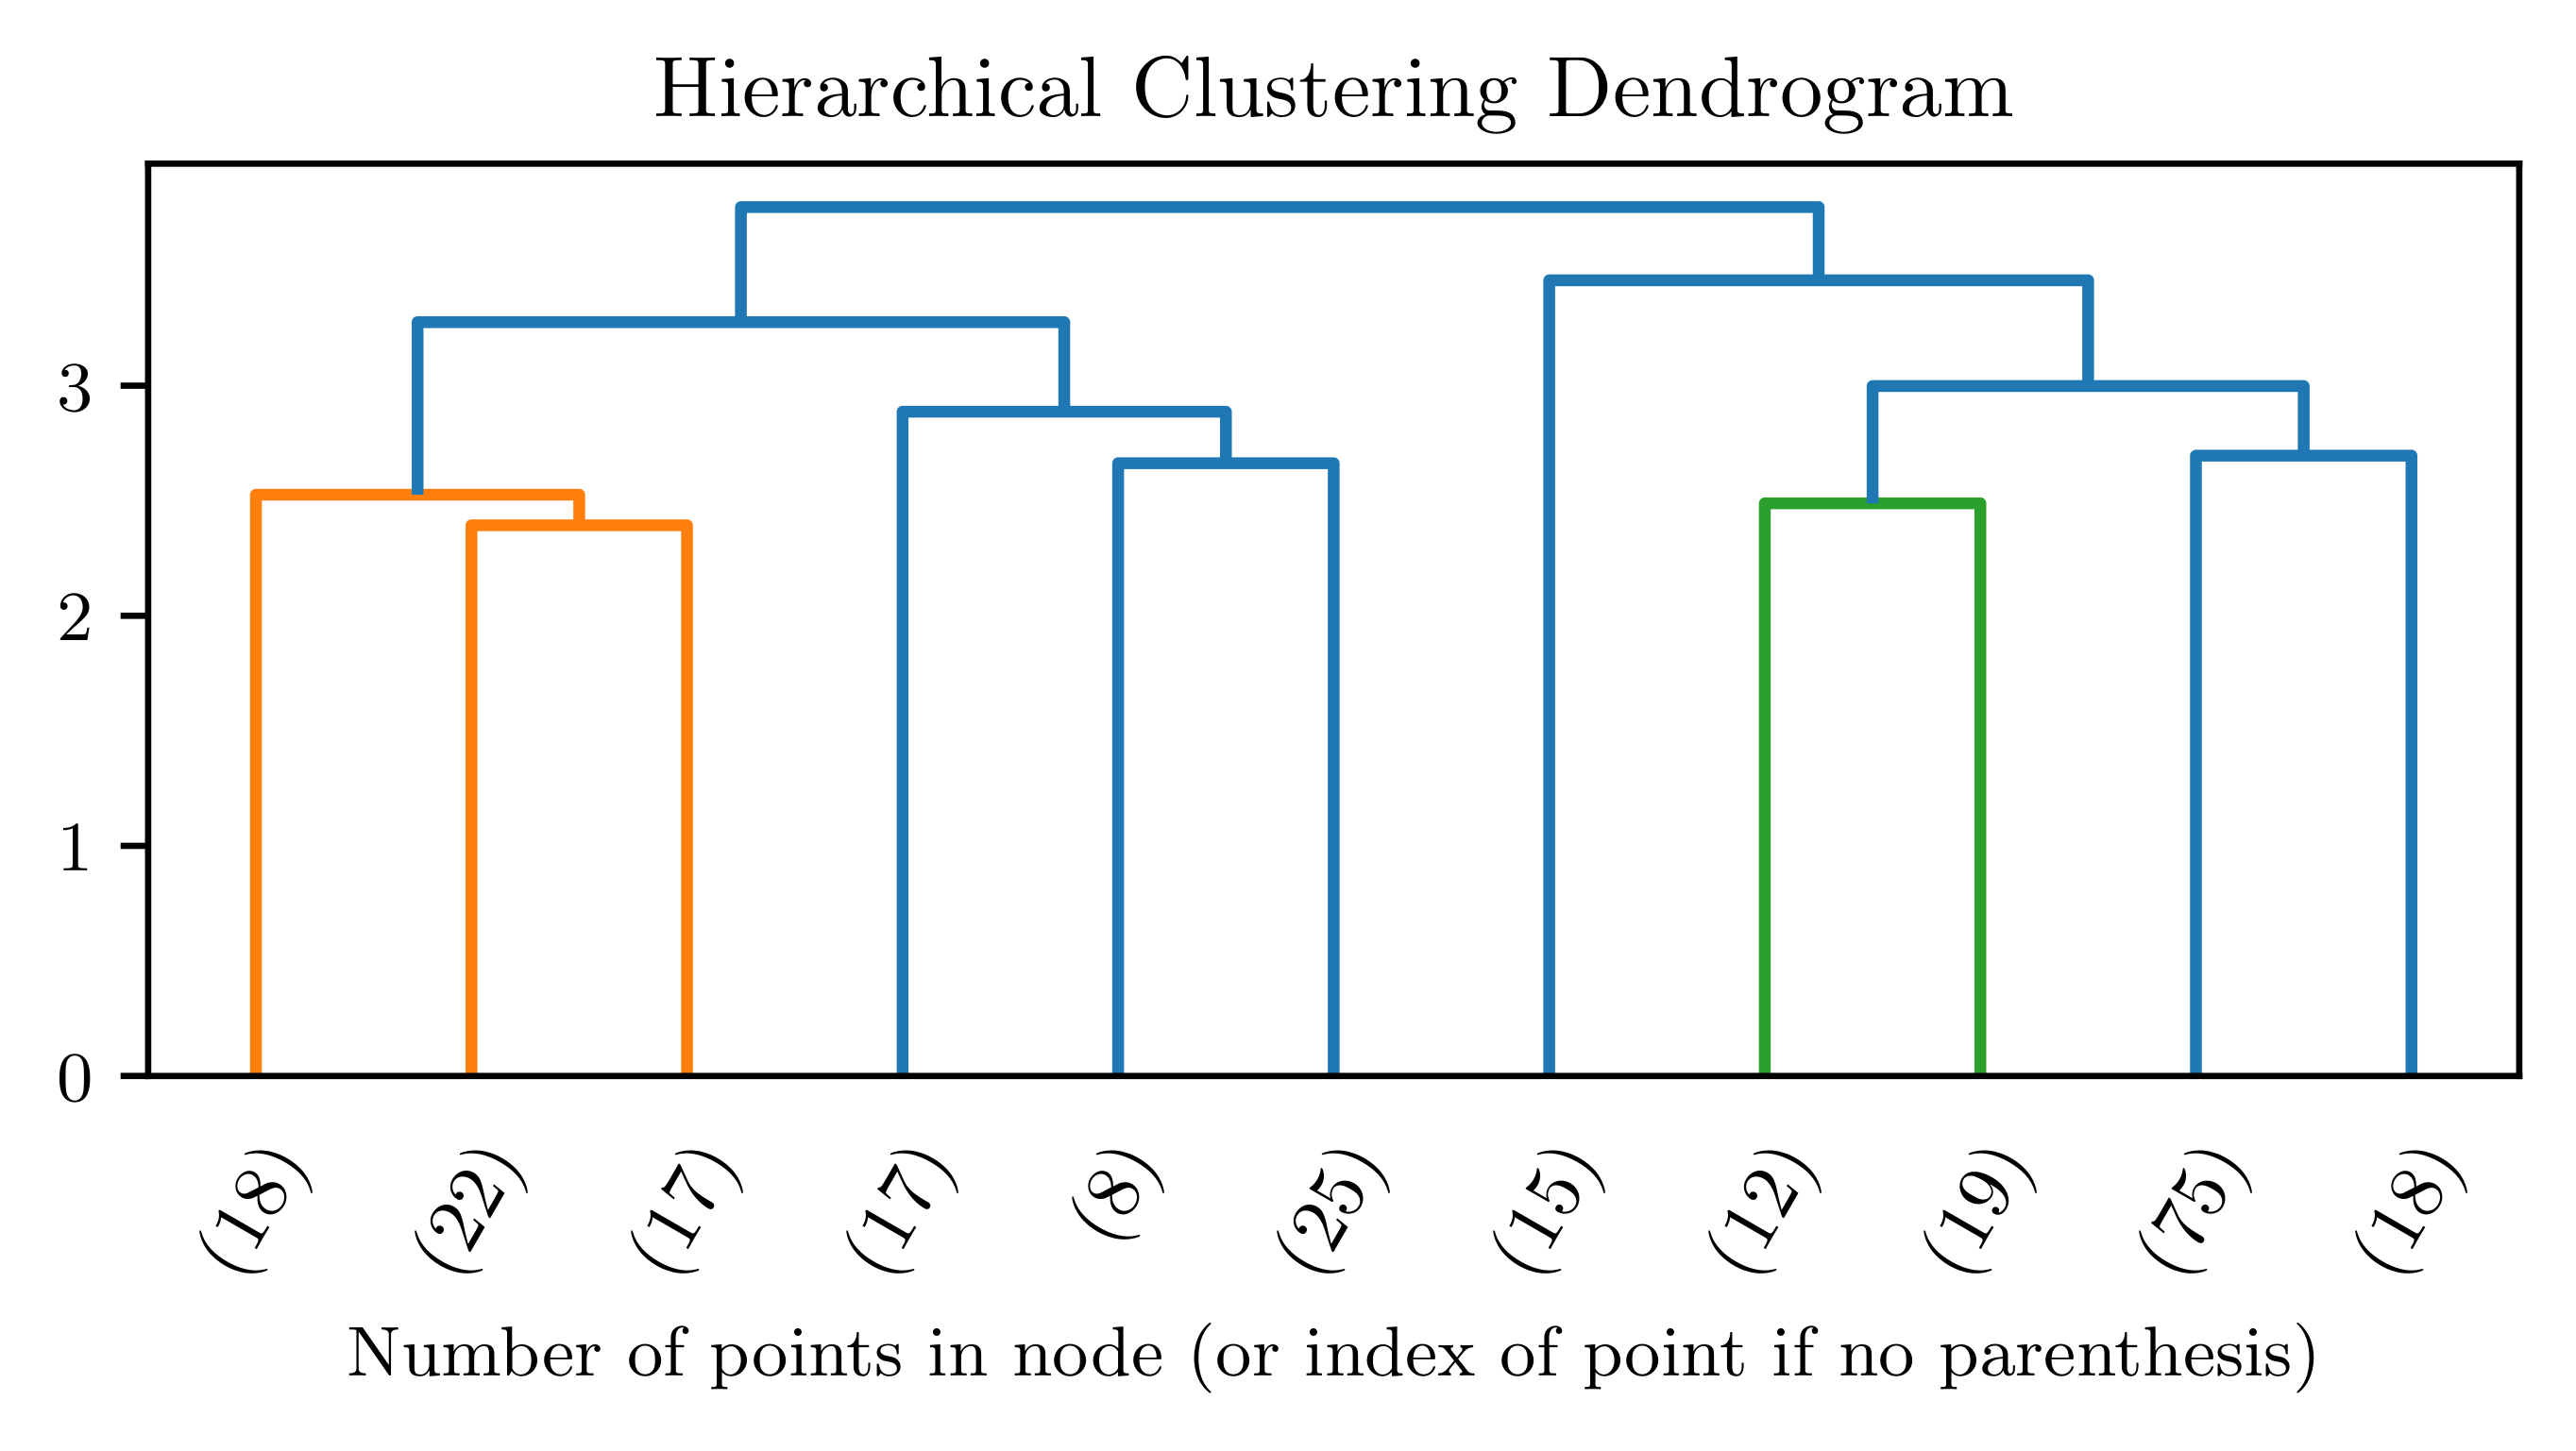

In [26]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendo = dendrogram(linkage_matrix, **kwargs)

    return linkage_matrix, dendo

plt.figure(figsize=(3240/600, 1280/600), dpi=600)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram

p = 11
linkageMatrix, dendoPlot = plot_dendrogram(model, truncate_mode="lastp", p=p, leaf_rotation=60.,leaf_font_size=10.)
#linkageMatrix, dendoPlot = plot_dendrogram(model, leaf_rotation=60.,leaf_font_size=3.)
plt.xlabel("Number of points in node (or index of point if no parenthesis)")
plt.savefig('D:/1. Papers/4. MyPapers/6_(20210609) Skill taxonomy/figures/denogrammClusteringRaw.png', dpi=600, bbox_inches = 'tight')
#print(dendoPlot["leaves"])

label = fcluster(linkageMatrix, p, criterion='maxclust')

#print(label)

d = {'primitive': clusteredEmb["primitive"].to_list(), 'label':label}
#print(d)

hierarchies = pd.DataFrame(d)

#print(hierarchies)


In [27]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# group by "X" column
groups = hierarchies.groupby('label')

labels = []
  
# extract keys from groups
keys = groups.groups.keys()

for i in keys:

    groups.get_group(i)

    n_gram_range = (1, 1)
    stop_words = "english"

    # Extract candidate words/phrases
    count = CountVectorizer(ngram_range=n_gram_range, stop_words = stop_words).fit(groups.get_group(i)['primitive'])
    candidates = count.get_feature_names()

    model = SentenceTransformer('msmarco-distilbert-base-tas-b')
    doc_embedding = model.encode(groups.get_group(i)['primitive'].to_list())
    candidate_embeddings = model.encode(candidates)

    top_n = 2
    distances = cosine_similarity(doc_embedding, candidate_embeddings)
    keywords = [candidates[index] for index in distances.argsort()[0][-top_n:]]
    print("GROUP: " + str(i))
    print(keywords)

    matchedKeywords = str(keywords[0] + "-" + keywords[1])
    print(matchedKeywords)


    
    labels.append(matchedKeywords)

    # put keywords on the hierechical clustering

print(labels)

GROUP: 1
['control', 'compliant']
control-compliant
GROUP: 2
['transition', 'wait']
transition-wait
GROUP: 3
['transportation', 'transport']
transportation-transport
GROUP: 4
['place', 'pick']
place-pick
GROUP: 5
['weight', 'compare']
weight-compare
GROUP: 6
['track', 'detect']
track-detect
GROUP: 7
['actuate', 'gripper']
actuate-gripper
GROUP: 8
['inspect', 'quality']
inspect-quality
GROUP: 9
['nut', 'screw']
nut-screw
GROUP: 10
['removal', 'remove']
removal-remove


In [ ]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering

dataset = sentence_embeddings

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(dataset)

print(len(dataset))


temp = {dendoPlot["leaves"][ii]: labels[ii] for ii in range(len(dendoPlot["leaves"]))}

print(len(dendoPlot["leaves"]))

def llf(xx):
    #print("{} - custom label!".format(temp[xx]))
    return "{}".format(temp[xx])

plt.title("Hierarchical Clustering Dendrogram")
linkageMatrix, dendoPlot = plot_dendrogram(model, truncate_mode="lastp", p=p, leaf_label_func=llf,leaf_rotation=60.,leaf_font_size=8., show_contracted=True)
plt.xlabel("Keywords expressing each cluster")